# Detecció d'opinions

In [19]:
# NLTK
import nltk
nltk.download('movie_reviews')
nltk.download('stopwords')
from nltk.corpus import movie_reviews as mr
from nltk.sentiment import SentimentIntensityAnalyzer

# typing
from typing import List, Tuple, Any, Dict, Type

# Sklearn
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Plots:
import matplotlib.pyplot as plt
import numpy as np

# Pickles:
import pickle


[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/barre/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to /home/barre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Requisitos para el typing
SklearnEstimator = Type[BaseEstimator]

In [4]:
#OUT
for cat in mr.categories():
    print(cat, len(mr.fileids(cat)))

neg 1000
pos 1000


In [5]:
def preprocess(review: str)-> str:
    """
    Función que preprocesa una review del corpus

    Parámetros:
    - review: string de una review

    Retorna:
    - review: un string con review preprocesada:
                - sin mayúsculas
                - sin dígitos
                - sin saltos de línea (\n)
                - lematizada cada palabra
                - separadas por " "
    """
    review = review.lower()
    # eliminate any character that is not a letter or a space
    review = ''.join(c for c in review if c.isalpha() or c == ' ')
    review = review.replace('\n', ' ')
    # convert all the words to its lemma
    lemmatizer = nltk.WordNetLemmatizer()
    
    review = ' '.join(lemmatizer.lemmatize(word) for word in review.split())
    # remove stopwords
    """stopwords = set(nltk.corpus.stopwords.words('english'))
    review = [w for w in review if w not in stopwords]
    review = ' '.join(review)"""
    return review

def split_corpus(X: List[str], y: list, test_size = 0.2, random_state = 42) -> Tuple[List, List, List, List]:
    """
    Función que divide el corpus y el vector y en X_train, X_test, y_train y y_test

    Parámetros:
    - x: list de str siendo str una review preprocesada y la lista conteniendo todas ellas
    - y: list compuesta de "pos" o "neg", según si la review del corpus con el mismo índice es positiva o negativa
    - test_size: float indicando proporción de test del corpus
    - random_state: int indicando la semilla para separar el corpus

    Retorna: 
    - X_train
    - X_test
    - y_train
    - y_test
        -> Conjunto de X e y separadas según train y test, siendo las X (train y test) vectorizadas
    """
    vectorizer = CountVectorizer()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    return X_train, X_test, y_train, y_test

corpus = [preprocess(mr.raw(review)) for review in mr.fileids()]
y = ["pos"]*1000 + ["neg"]*1000 

X_train, X_test, y_train, y_test = split_corpus(corpus, y)


In [5]:
print(y_test)

['neg', 'pos', 'neg', 'pos', 'neg', 'neg', 'pos', 'neg', 'pos', 'neg', 'pos', 'neg', 'neg', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos', 'neg', 'neg', 'neg', 'pos', 'pos', 'neg', 'pos', 'pos', 'neg', 'pos', 'pos', 'pos', 'pos', 'neg', 'neg', 'pos', 'neg', 'pos', 'pos', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'pos', 'neg', 'neg', 'pos', 'neg', 'neg', 'pos', 'pos', 'neg', 'pos', 'pos', 'neg', 'pos', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos', 'pos', 'neg', 'neg', 'neg', 'pos', 'pos', 'neg', 'neg', 'pos', 'neg', 'neg', 'neg', 'pos', 'pos', 'pos', 'neg', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'neg', 'neg', 'pos', 'pos', 'neg', 'pos', 'pos', 'neg', 'neg', 'neg', 'neg', 'pos', 'pos', 'neg', 'pos', 'pos', 'neg', 'pos', 'neg', 'neg', 'pos', 'pos', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg'

## Utilitzant una Multinomial

### Gridsearch - Encontramos los mejores hiperparámetros

{'alpha': 3.0}
0.8099999999999999


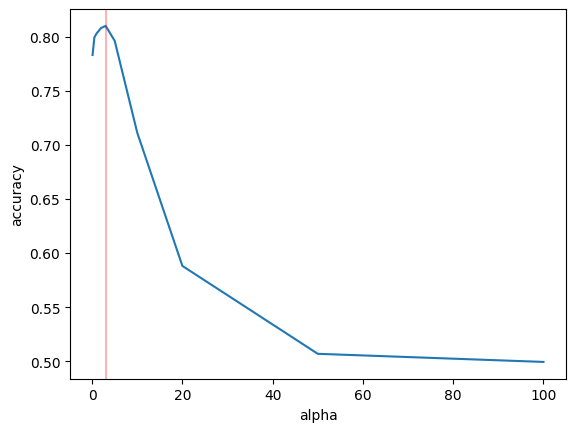

In [6]:


def grid_search(classifier: SklearnEstimator, param_grid: Dict[str, list], kfolds = 5) -> Tuple[GridSearchCV, float]:
    """
    Función que realiza una búsqueda ambiciosa, maximizando la accuracy con disintas alphas

    Parámetros:
    - classifier: tipo de modelo clasificador que queremos optimizar
    - param_grid: diccionario con las alpha-s a utilizar ({"alpha": List[alpha-s]})
    - kfolds: numero de subsets de validación que se utilizarán para evitar overfitting

    Retorna:
    - grid_search: instancia de GridSearchCV, habiendo buscado en la separación train del corpus
    """
    grid_search = GridSearchCV(classifier, param_grid, cv=kfolds)
    grid_search.fit(X_train, y_train)

    print(grid_search.best_params_)
    print(grid_search.best_score_)
    return grid_search


def plot_gridsearch(grid: GridSearchCV, param_grid: Dict[str, list], x, y, xlab, ylab, z=None):
    """
    Función que crea una gráfica con los resultados de la búsqueda ambiciosa

    Parámetros:
    - grid: instancia de GridSearchCV con la búsqueda "greedy" con distintos alpha-s 
    - param_grid: dict conteniendo las alpha-s con las que se ha realizado la búsqueda
    - x: string con la variable de param_grid que pertenecerá al eje x
    - y: string con la variable de param_grid que pertenecerá al eje y, normalmente la métrica de performance
    - xlab: label del eje x
    - ylab: label del eje y
    - z: en caso de querer ver algún otro parámetro, string con el parámetro que creará líneas de distintos colores para cada valor de dicho parámetro, en función de la x y la y
         es None por defecto 
    
    """

    scores = grid.cv_results_[y]

    length_x = len(param_grid[x])
    if z != None:
        length_z = len(param_grid[z])
    else:
        length_z = 1

    for i in range(length_z):
        plt.plot(param_grid[x], scores[i*length_x:(i+1)*length_x])
    
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.axvline(grid.best_params_[x], color='r',alpha = 0.3)
    if z!= None:
        plt.legend(param_grid[z])
    plt.show()

# fem gridsearch per trobar el millor parametre alpha
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0,3.0,5.0,10.0,20.0,50.0,100.0]}

grid_multinomial = grid_search(MultinomialNB(), param_grid)
plot_gridsearch(grid_multinomial, param_grid, "alpha", "mean_test_score", "alpha", "accuracy")

In [7]:
classifier = MultinomialNB(alpha=grid_multinomial.best_params_["alpha"])
classifier.fit(X_train, y_train)

MultinomialNB(alpha=3.0)

## Utilitzant Support Vector Machine

### Gridsearch - Trobem els millors hiperparàmetres

In [11]:
svc_parameters = {'kernel':('linear', 'rbf'), 'C':[0.1,1,5,10,20]}
svc = SVC()
grid_svc = grid_search(SVC(), svc_parameters)

{'C': 0.1, 'kernel': 'linear'}
0.8225


In [36]:
SVC_file = "./bin/SVC_grid_search.bin"

with open(SVC_file, "wb+") as file:
    pickle.dump(grid_svc, file)


In [37]:
with open(SVC_file, "rb") as file:
    grid_svc = pickle.load(file)

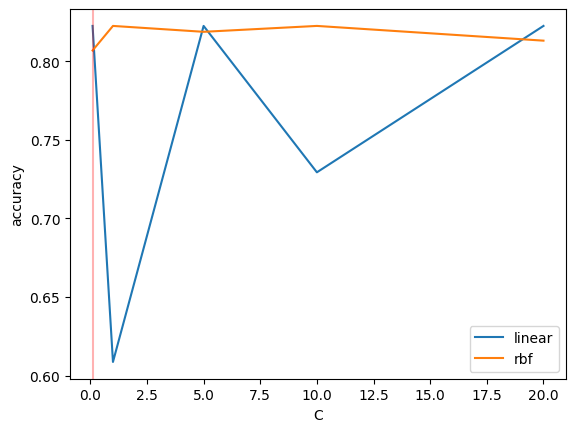

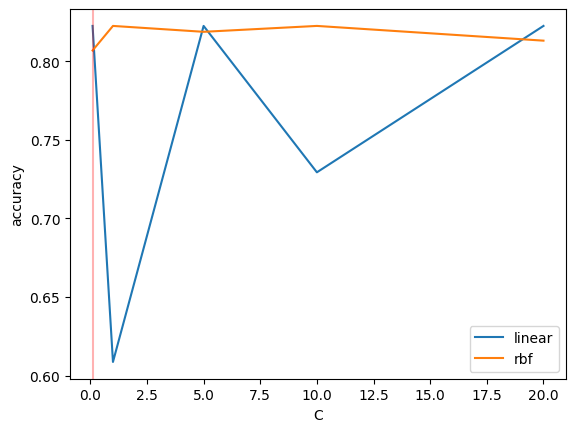

In [56]:
# plot only the linear kernel and its score depending on the C parameter
plot_gridsearch(grid_svc, svc_parameters, "C", "mean_test_score", "C", "accuracy", "kernel")

"""scores = grid_svc.cv_results_['mean_test_score']
C = [0.1,1,5,10,20]
plt.plot(C, scores[:5])
plt.xlabel('C')
plt.ylabel('accuracy')
plt.plot(C, scores[5:])
plt.axvline(grid_svc.best_params_['C'], color='r', alpha = 0.3)
# legend
plt.legend(['linear', 'rbf'])
plt.show()"""

In [37]:
classifier = SVC(kernel='rbf', C=10)
classifier.fit(X_train, y_train)

SVC(C=10)

# Utilitzant regressió logística

In [13]:
from sklearn.linear_model import LogisticRegression
parameters_logreg = {'C':[0.1,1,5,10,20,30,50,75,100]}
logreg = LogisticRegression(max_iter=1000)
grid_logreg = grid_search(logreg, parameters_logreg)


{'C': 10}
0.838125


In [39]:
LogReg_file = "./bin/log_reg_grid_search.bin"

with open(LogReg_file, "wb+") as file:
    pickle.dump(grid_logreg, file)


In [40]:
with open(LogReg_file, "rb") as file:
    grid_logreg = pickle.load(file)

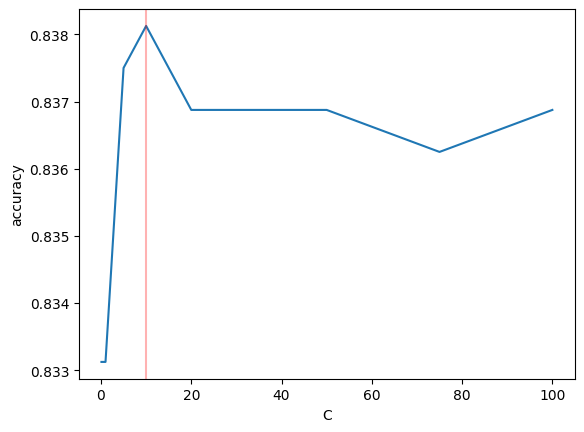

"\nscores = grid_logreg.cv_results_['mean_test_score']\nC = [0.1,1,5,10,20,30,50,75,100]\nplt.plot(C, scores)\nplt.xlabel('C')\nplt.ylabel('accuracy')\nplt.axvline(grid_logreg.best_params_['C'], color='r', alpha = 0.3)\nplt.show()"

In [41]:
# plot the results of the gridsearch
plot_gridsearch(grid_logreg, parameters_logreg, "C", "mean_test_score", "C", "accuracy")
"""
scores = grid_logreg.cv_results_['mean_test_score']
C = [0.1,1,5,10,20,30,50,75,100]
plt.plot(C, scores)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.axvline(grid_logreg.best_params_['C'], color='r', alpha = 0.3)
plt.show()"""

In [40]:
classifier = LogisticRegression(C = grid_logreg.best_params_["C"], max_iter=1000)
classifier.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000)

## Utilitzant random forest

### Gridsearch - Trobem els millors hiperparàmetres

In [49]:
from sklearn.ensemble import RandomForestClassifier
params_rndm_forest = {'n_estimators': [10, 25, 50, 100], 'max_depth': [None, 10, 20, 30, 40, 50]}
grid_rndm_forest = grid_search(RandomForestClassifier(), params_rndm_forest)

In [44]:
RndmForest_file = "./bin/rndm_forest_grid_search.bin"

with open(RndmForest_file, "wb+") as file:
    pickle.dump(grid_rndm_forest, file)

In [47]:
with open(RndmForest_file, "rb+") as file:
    grid_rndm_forest = pickle.load(file)

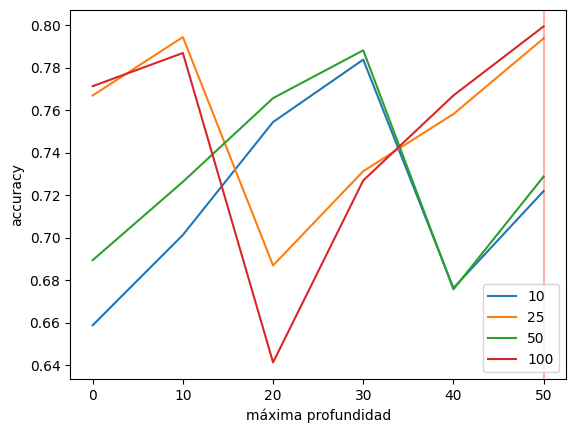

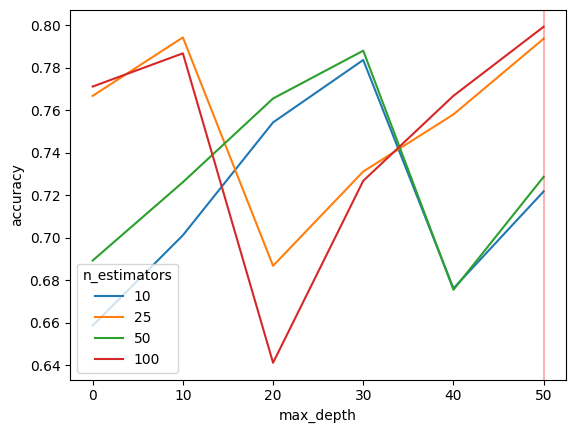

In [57]:

params_rndm_forest["max_depth"][0] = 0
plot_gridsearch(grid_rndm_forest, params_rndm_forest, "max_depth", "mean_test_score", "máxima profundidad", "accuracy", "n_estimators")


"""scores = grid_rndm_forest.cv_results_['mean_test_score']
max_depth = [0, 10, 20, 30, 40, 50]

# fem un plot de cada n_estimators amb el seu color
for i in range(4):
    plt.plot(max_depth, scores[i*6:(i+1)*6])

plt.legend(['10', '25', '50', '100'], title = 'n_estimators')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.axvline(grid_rndm_forest.best_params_['max_depth'], color='r', alpha = 0.3)
plt.show()"""



In [43]:
classifier = RandomForestClassifier(n_estimators=100,max_depth=30, random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, random_state=42)

## Fem les proves amb Test

In [44]:
scores = {}

In [45]:
accuracy = classifier.score(X_test, y_test)
print("Accuracy:", accuracy)
name = str(classifier)
scores[str(name)] = accuracy

Accuracy: 0.79


In [46]:
# predict the category of a new review
new_review = "I love this movie, it is the best movie i have ever seen"
new_review = preprocess(new_review)
print(new_review)
new_review_vec = vectorizer.transform([new_review])
print(classifier.predict(new_review_vec))

i love this movie it is the best movie i have ever seen


NotFittedError: Vocabulary not fitted or provided

              precision    recall  f1-score   support

         neg       0.82      0.77      0.79       201
         pos       0.78      0.83      0.80       199

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



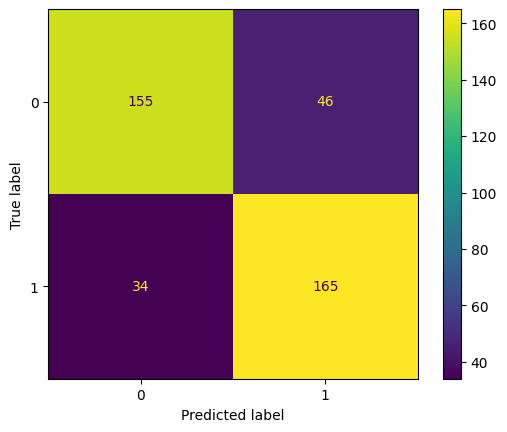

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
results = classifier.predict(X_test)
print(classification_report(y_test, results))
conf_matrix = confusion_matrix(y_test, results)
conf_matrix = ConfusionMatrixDisplay(conf_matrix)
conf_matrix.plot()
plt.show()


In [ ]:
import pandas as pd
df = pd.DataFrame(scores, index=[0])
# set the first row name as "accuracy"
df = df.rename(index={0: "Accuracy:"})
# change the fourth column name to Random forest
df = df.rename(columns={str(classifier): "RandomForest(n = 25)"})
df.head(1)


,SVC(C=5),"RandomForestClassifier(max_depth=30, random_state=42)","RandomForestClassifier(max_depth=30, n_estimators=50, random_state=42)","LogisticRegression(C=10, max_iter=1000)",SVC(C=10),RandomForest(n = 25)
Accuracy:,0.8,0.79,0.75,0.825,0.825,0.8125


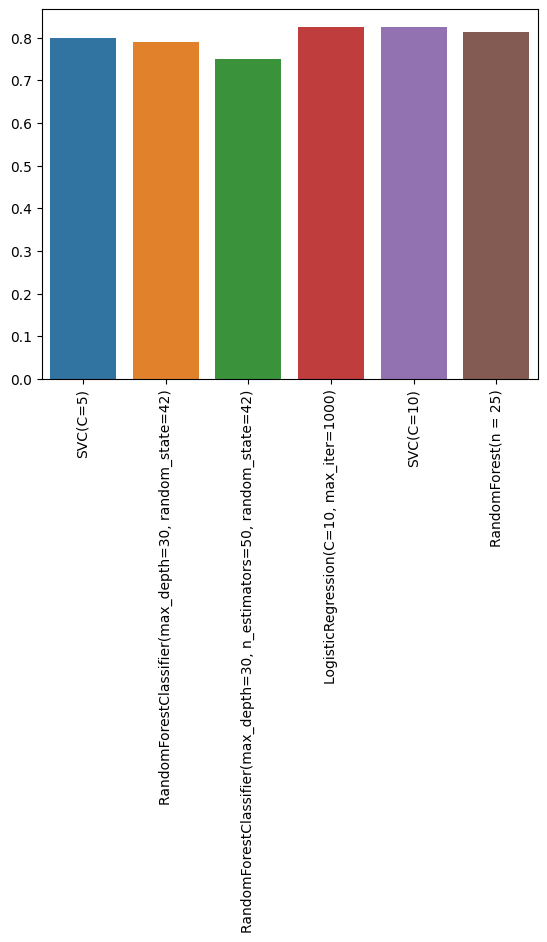

In [ ]:
# make a barplot to compare scores of df
sns.barplot(data=df)
# put the labels diagonally
plt.xticks(rotation=90)
plt.show()